# Regression Models
In this notebook, we build regression models to predict the citattion count of arXiv papers, given other features. Topic modeling is implemented on the title and abstract, and we train the following regression ML models: 

- Linear regression

- Support vector machine regressor

- Random forest regressor

- LGBM regressor

In [2]:
%matplotlib inline

# Filter warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict

plt.rcParams.update({'font.size': 18})

In [3]:
# Import custom class
%run -i '../src/helper/ml.py'
%run -i '../src/helper/imputer.py'
%run -i '../src/helper/transfxn.py'
%run -i '../src/helper/text_preprocessing.py'

In [4]:
# Instantiate the  classes
transfxn = TransformationPipeline()
text_tf = TextPreprocessing()
imputer = DataFrameImputer()
model = RegressionModels()

# Load data

In [5]:
df = pd.read_csv('../data/data_processed.csv', sep = '\t')
print('Data size', df.shape)
cols = ['arXiv_id', 'title', 'abstract', 'authors', 'year']
df[cols].head()

Data size (295174, 20)


,arXiv_id,title,abstract,authors,year
0,704.0006,Bosonic characters of atomic Cooper pairs acro...,We study the two-particle wave function of p...,"['PongY. H.', 'LawC. K.']",2007
1,704.0008,Numerical solution of shock and ramp compressi...,A general formulation was developed to repre...,['SwiftDamian C.'],2007
2,704.0025,Spectroscopic Properties of Polarons in Strong...,We present recent advances in understanding ...,"[""MishchenkoA. S.CREST, Japan Science and Tech...",2007
3,704.0027,Filling-Factor-Dependent Magnetophonon Resonan...,We describe a peculiar fine structure acquir...,"['GoerbigM. O.', 'FuchsJ. -N.', 'KechedzhiK.',...",2007
4,704.003,Tuning correlation effects with electron-phono...,We investigate the effect of tuning the phon...,"['HagueJ. P.', ""d'AmbrumenilN.""]",2007


# Data types and missing values

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295174 entries, 0 to 295173
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   abstract         295174 non-null  object 
 1   arXiv_id         295174 non-null  object 
 2   authors          295174 non-null  object 
 3   categories       295174 non-null  object 
 4   comments         295173 non-null  object 
 5   date_created     295174 non-null  object 
 6   doi              295174 non-null  object 
 7   title            295174 non-null  object 
 8   num_of_authors   295174 non-null  int64  
 9   year             295174 non-null  int64  
 10  month            295174 non-null  object 
 11  day_of_week      295174 non-null  object 
 12  num_of_pages     196991 non-null  float64
 13  num_of_figures   158440 non-null  float64
 14  length_of_abstr  295174 non-null  int64  
 15  citation_count   295174 non-null  int64  
 16  p_age            295174 non-null  int6

In [6]:
df.describe()

,num_of_authors,year,num_of_pages,num_of_figures,length_of_abstr,citation_count,p_age,wday_ct,month_ct,year_ct
count,295174.000000,295174.000000,196991.000000,158440.000000,295174.000000,295174.000000,295174.000000,295174.000000,295174.000000,295174.000000
mean,3.889807,2010.527292,12.863730,6.593228,897.299322,24.929008,9.472708,48839.456158,24657.074336,13245.038696
std,2.922733,6.794057,15.897621,14.012105,351.711874,99.294934,6.794057,11700.358312,1191.903409,4308.690391
min,1.000000,1992.000000,0.000000,0.000000,7.000000,0.000000,0.000000,14925.000000,22499.000000,284.000000
25%,2.000000,2005.000000,5.000000,4.000000,639.000000,1.000000,4.000000,47270.000000,23902.000000,10239.000000
50%,3.000000,2012.000000,10.000000,5.000000,843.000000,7.000000,8.000000,54235.000000,24968.000000,14743.000000
75%,5.000000,2016.000000,16.000000,8.000000,1107.000000,23.000000,15.000000,54239.000000,25778.000000,16731.000000
max,141.000000,2020.000000,2008.000000,4989.000000,6091.000000,19719.000000,28.000000,54592.000000,26325.000000,18895.000000


# Distribution of the target variable

Text(0, 0.5, 'Count')

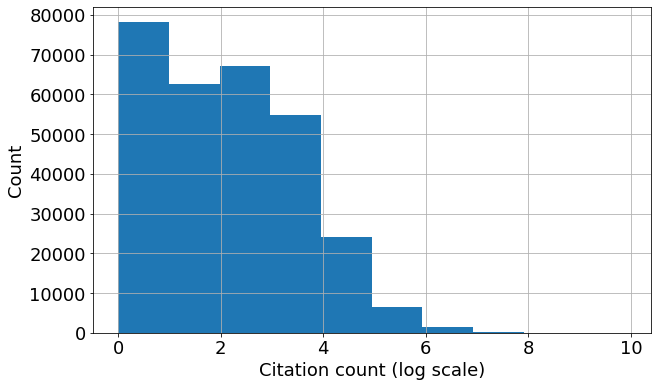

In [7]:
np.log1p(df['citation_count']).hist(figsize = (10,6))
plt.xlabel('Citation count (log scale)')
plt.ylabel('Count')

# Reduce the dataset
We reduce the dataset to speed up training of the models

In [9]:
X1, X2, y1, y2 = train_test_split(df, df['citation_count'], test_size = 0.04, random_state = 42)

In [10]:
print('Large subset size:', X1.shape, y1.shape)
print('Small subset size:', X2.shape, y2.shape)

Large subset size: (283367, 20) (283367,)
Small subset size: (11807, 20) (11807,)


In [12]:
# pickle the small subset
X2.to_pickle('../data/_data.pkl')

In [13]:
# reload the small subset
df_small = pd.read_pickle('../data/_data.pkl').reset_index(drop = True)

In [14]:
# join the title & abstract
df_small['docs'] = df_small['abstract'] + df_small['title']

# Topic modeling with LDA

In [15]:
# bow vector
X, vocab  = text_tf.bow_vector(df_small, text_col = 'docs')
print('Data size of bow vector:', X.shape)

Data size of bow vector: (11807, 117690)


In [16]:
# LDA with 20 topics
lda = LDA(n_components = 20, learning_method = 'batch', random_state = 42)
lda.fit(X) # fit model
print("LDA model size:", lda.components_.shape)

LDA model size: (20, 117690)


In [17]:
topics = ['topic{}'.format(i) for i in range(lda.components_.shape[0])]
components = pd.DataFrame(lda.components_.T, index=vocab, columns = topics)/len(X)
n_top_words = 10
for i, topic_dist in enumerate(topics):
    topic_words = components[topics[i]].sort_values(ascending = False)[:n_top_words].index
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: model system energy scale high temperature state critical quantum field
Topic 1: theory order field layer effect electron structure temperature interface energy
Topic 2: model network system quantum random dynamic distribution equation transition scale
Topic 3: quantum couple system state optical control photon device single electron
Topic 4: magnetic spin field time temperature function structure surface phase wave
Topic 5: nanotube carbon interaction model charge transition field structure calculation property
Topic 6: magnetic field current spin domain magnetization wall electron effect torque
Topic 7: graphene effect hall dirac band transport density layer material property
Topic 8: model function method equation state energy theory condensate approach system
Topic 9: junction tunnel josephson current layer voltage system film large effect
Topic 10: property structure polymer field potential experimental current method strong boron
Topic 11: phase model surface particle fi

In [18]:
topic_vector = lda.transform(X) # extract the topic vector

In [19]:
# create topic vector dataframe
cols = ['topic{}'.format(i) for i in range(lda.components_.shape[0])]
df_topic_vec = pd.DataFrame(topic_vector, columns = cols)
df_topic_vec.insert(loc =0, column= 'arXiv_id', value = df_small.arXiv_id)
df_topic_vec.round(2).head()

,arXiv_id,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,...,topic10,topic11,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19
0,1602.0538,0.0,0.00,0.04,0.00,0.0,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.37,0.00,0.0,0.58,0.0
1,903.4132,0.0,0.00,0.28,0.00,0.0,0.0,0.0,0.00,0.65,...,0.0,0.0,0.0,0.0,0.0,0.00,0.06,0.0,0.00,0.0
2,1710.08448,0.0,0.32,0.24,0.00,0.0,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.43,0.00,0.0,0.00,0.0
3,1004.3886,0.0,0.00,0.00,0.86,0.0,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.10,0.0
4,1705.01617,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.05,0.00,...,0.0,0.0,0.0,0.0,0.0,0.00,0.95,0.0,0.00,0.0


# Final dataframe

In [20]:
cols_to_drop = ['abstract', 'authors','categories', 'date_created', 
               'doi', 'title', 'comments', 'docs']
df_cnsld = df_small.merge(df_topic_vec, how = 'inner', on = 'arXiv_id')
df_cnsld.drop(cols_to_drop, axis=1, inplace=True)

# Log(1+x) transformation of the target variable
df_cnsld['log_citation_count'] = np.log1p(df_cnsld['citation_count']) 
df_cnsld.head()

,arXiv_id,num_of_authors,year,month,day_of_week,num_of_pages,num_of_figures,length_of_abstr,citation_count,p_age,...,topic11,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,log_citation_count
0,1602.0538,2,2016,February,Wednesday,13.0,15.0,1017,1,4,...,0.000602,0.000602,0.000602,0.000602,0.370589,0.000602,0.000602,0.581287,0.000602,0.693147
1,903.4132,6,2009,March,Tuesday,9.0,3.0,1578,6,11,...,0.000379,0.000379,0.000379,0.000379,0.000379,0.062907,0.000379,0.000379,0.000379,1.945910
2,1710.08448,3,2017,October,Monday,11.0,NaN,1080,4,3,...,0.000581,0.000581,0.000581,0.000581,0.429360,0.000581,0.000581,0.000581,0.000581,1.609438
3,1004.3886,1,2010,April,Thursday,NaN,NaN,263,0,10,...,0.002174,0.002174,0.002174,0.002174,0.002174,0.002174,0.002174,0.096940,0.002174,0.000000
4,1705.01617,9,2017,May,Wednesday,NaN,13.0,1917,74,3,...,0.000323,0.000323,0.000323,0.000323,0.000323,0.946719,0.000323,0.000323,0.000323,4.317488


# Feature matrix and target variable

In [21]:
# feature matrix and class label
cols_to_drop = ['arXiv_id', 'citation_count', 'log_citation_count']
X, y = df_cnsld.drop(cols_to_drop, axis = 1), df_cnsld['log_citation_count']
print('Data size:', X.shape, y.shape)

Data size: (11807, 31) (11807,)


# Create a test set
Create $80\%$ training set and $20\%$ test set

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [23]:
print('Training set size:', X_train.shape, y_train.shape)
print('Test set size:', X_test.shape, y_test.shape)

Training set size: (9445, 31) (9445,)
Test set size: (2362, 31) (2362,)


# Transformation pipeline

# 1. Impute missing values

In [24]:
# Fit transform the training set
X_train_imputed = imputer.fit_transform(X_train)

# Only transform the test set
X_test_imputed = imputer.transform(X_test)

# 2. Pre-processing

In [25]:
# Transform and scale data
X_train_scaled, X_test_scaled, feat_nm = transfxn.preprocessing(X_train_imputed, X_test_imputed)

In [26]:
print('Training set size after pre-processing:', X_train_scaled.shape)
print('Test set size after pre-processing:', X_test_scaled.shape)

Training set size after pre-processing: (9445, 48)
Test set size after pre-processing: (2362, 48)


In [27]:
# Convert the class labels to arrays
y_train, y_test = y_train.values,  y_test.values

# Model Selection by Cross-Validation

# A. Linear Regression

In [28]:
lr = LinearRegression()
model.eval_metric_cv(lr, X_train_scaled, y_train, cv_fold = 10, 
                    model_nm = 'Linear regression')

10-Fold cross-validation results for Linear regression
---------------------------------------------
{'R^2 = 0.153', 'MAE = 1.106', 'RMSE = 1.362'}
---------------------------------------------


# B. Support Vector Regressor

In [29]:
svr = SVR()
model.eval_metric_cv(svr, X_train_scaled, y_train, cv_fold = 10, 
                    model_nm = 'SVM regressor')

10-Fold cross-validation results for SVM regressor
---------------------------------------------
{'RMSE = 1.387', 'MAE = 1.118', 'R^2 = 0.122'}
---------------------------------------------


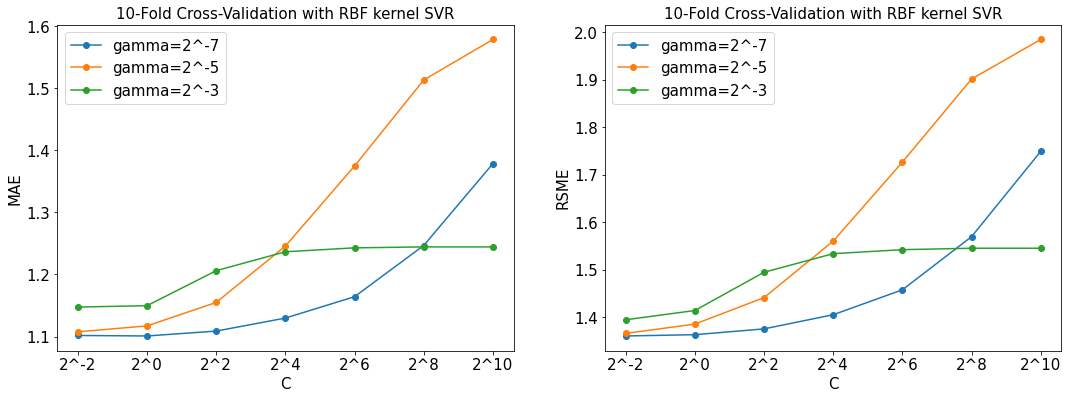

In [30]:
# Plot MAE and RMSE with different hyperparamters
model.plot_mae_rsme_svr(X_train_scaled, y_train, cv_fold = 10)

# B-1. Hyperparameter Optimization for SVR
We now optimize the MAE of Support vector regressor using randomized search

In [31]:
# Range of hyperparameters
params = {'C': [2**x for x in range(-2,11,2)], 
          'gamma': [2**x for x in range(-11,1,2)]
          } 
                                                              
# Randomized search for SVR
rsearch_svr = RandomizedSearchCV(estimator = SVR(), param_distributions = params, 
                                n_iter = 200,scoring = 'neg_mean_absolute_error',
                                cv = 10, n_jobs = -1, random_state = 42, verbose = 1
                                ) 
# Fit the training set
rsearch_svr.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_svr.best_estimator_, '../data/svr.pkl')

print('Best MAE score:', -rsearch_svr.best_score_)
print('Best parameters:', rsearch_svr.best_params_)  

Fitting 10 folds for each of 42 candidates, totalling 420 fits
Best MAE score: 1.098763233380396
Best parameters: {'gamma': 0.00048828125, 'C': 64}


# C. Random Forest Regressor

In [32]:
rf = RandomForestRegressor(random_state = 42) 
model.eval_metric_cv(rf, X_train_scaled, y_train, cv_fold = 10, model_nm = 'Random forest regressor')

10-Fold cross-validation results for Random forest regressor
---------------------------------------------
{'MAE = 1.107', 'R^2 = 0.144', 'RMSE = 1.369'}
---------------------------------------------


# C-1. Feature Importances for RF

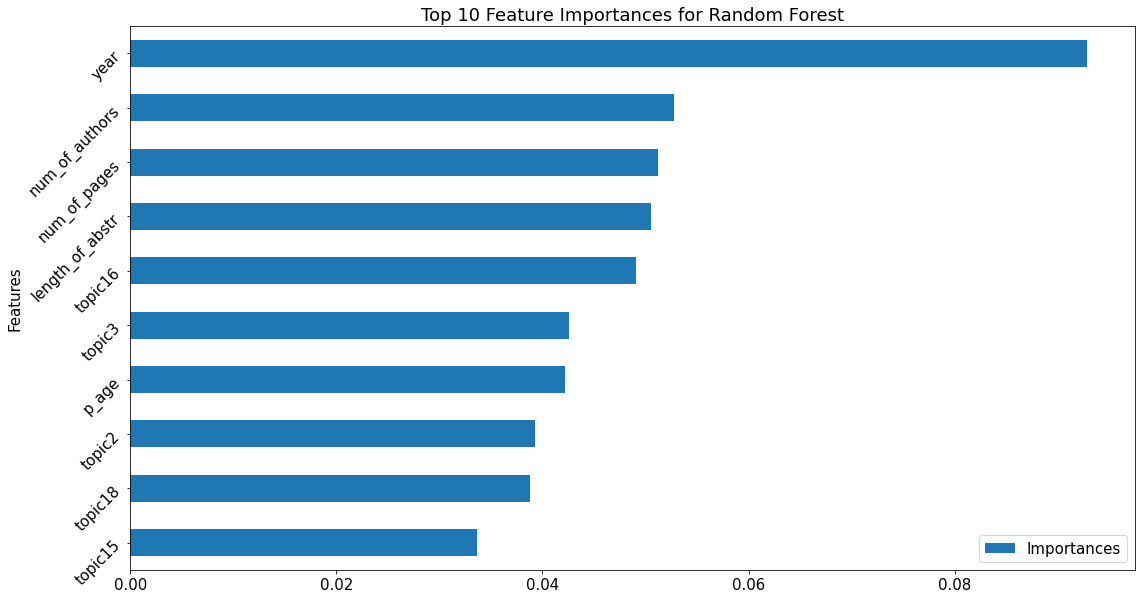

In [33]:
# Compute feature importances
importances_df = pd.DataFrame({'Features': feat_nm, 
                               'Importances': rf.feature_importances_})
# Plot
importances_df.sort_values('Importances', ascending = True, inplace = True)
importances_df.set_index('Features', inplace = True)
importances_df.tail(10).plot(kind='barh', figsize = (18,10))
plt.yticks(rotation = 45)
plt.title('Top 10 Feature Importances for Random Forest')
plt.savefig('../images/rf.png')

# C-2. Hyperparameter Optimization for RF
We now optimize the MAE of Random forest regressor using randomized search

In [34]:
# Hyperparameter range
params = {'max_features': ['auto', 'sqrt', 'log2'],
          'max_depth': [10, 20, 30, None],
          'min_samples_split': range(2,10,1),
          'bootstrap': [True, False]}

# Randomized search
rf =  RandomForestRegressor(n_estimators = 1000, random_state = 42)                       
rsearch_rf = RandomizedSearchCV(estimator = rf, param_distributions = params, 
                                n_iter = 200,scoring = 'neg_mean_absolute_error',
                                cv = 10, n_jobs = -1, random_state = 42, verbose = 1)  

# Fit model
rsearch_rf.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_rf.best_estimator_, '../data/rf.pkl')

# Print results
print('Best MAE score:', -rsearch_rf.best_score_) 
print('Best hyperparameters:', rsearch_rf.best_params_) 

Fitting 10 folds for each of 192 candidates, totalling 1920 fits
Best MAE score: 1.098271958464033
Best hyperparameters: {'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}


# D. LGBM Regressor

In [35]:
param_dict = {'boosting_type':'gbdt', 'num_leaves':31, 'max_depth':- 1, 
              'learning_rate':0.1, 'n_estimators':100, 'random_state':42}
              
lgbm = lgb.LGBMRegressor(**param_dict)
model.eval_metric_cv(lgbm, X_train_scaled, y_train, cv_fold = 10, model_nm = 'LGBM regressor')

10-Fold cross-validation results for LGBM regressor
---------------------------------------------
{'RMSE = 1.355', 'MAE = 1.097', 'R^2 = 0.161'}
---------------------------------------------


# D-1. Feature Importances for LGBM

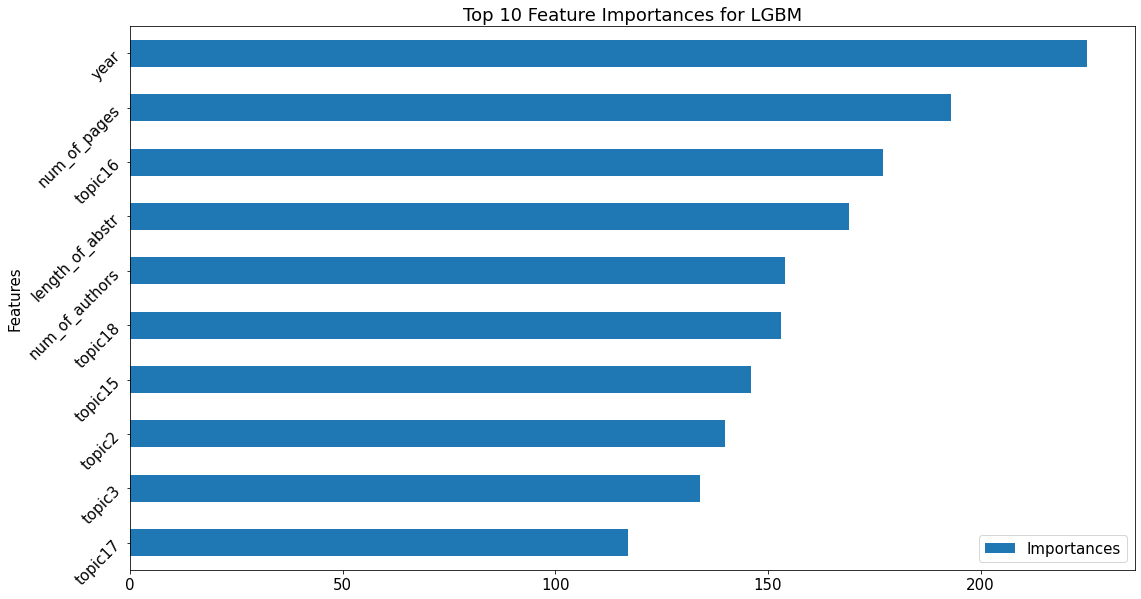

In [36]:
# Compute feature importances
importances_df = pd.DataFrame({'Features': feat_nm, 
                               'Importances': lgbm.feature_importances_})
# Plot
importances_df.sort_values('Importances', ascending = True, inplace = True)
importances_df.set_index('Features', inplace = True)
importances_df.tail(10).plot(kind='barh', figsize = (18,10))
plt.yticks(rotation = 45)
plt.title('Top 10 Feature Importances for LGBM')
plt.savefig('../images/lgbm.png')

# D-2. Hyperparameter Optimization for LGBM
We now optimize the MAE of LGBM regressor using randomized search

In [37]:
# Hyperparameter range
params = {'max_depth': [10, 20, 30],
          'num_leaves': range(90,120,5),
          'min_child_samples': range(20,50,10)
          }

# Randomized search
lgbm =  lgb.LGBMRegressor(n_estimators = 1000, random_state =42)                       
rsearch_lgbm = RandomizedSearchCV(estimator = lgbm, param_distributions = params, 
                                n_iter = 200,scoring = 'neg_mean_absolute_error',
                                cv = 10, n_jobs = -1, random_state = 42, verbose = 1)  
# Fit model
rsearch_lgbm.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_lgbm.best_estimator_, '../data/lgbm.pkl')

# Print results
print('Best MAE score:', -rsearch_lgbm.best_score_) 
print('Best hyperparameters:', rsearch_lgbm.best_params_) 

Fitting 10 folds for each of 54 candidates, totalling 540 fits
Best MAE score: 1.1518199948621795
Best hyperparameters: {'num_leaves': 110, 'min_child_samples': 20, 'max_depth': 30}


In [38]:
# Load trained model
svr = joblib.load('../data/svr.pkl')
rf = joblib.load('../data/rf.pkl')
lgbm = joblib.load('../data/lgbm.pkl')

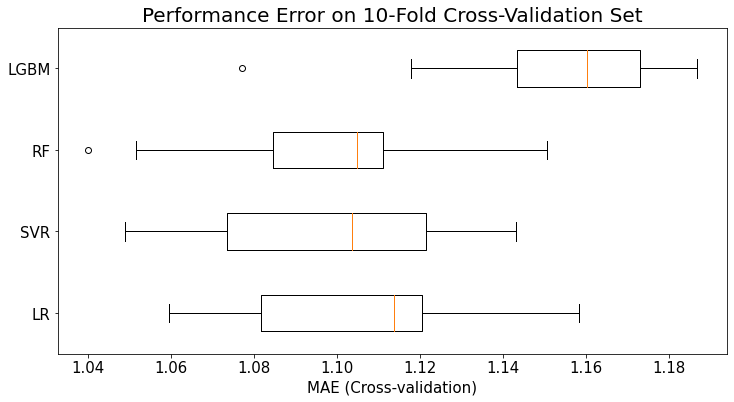

In [39]:
model_dict = {'LR': lr, 'SVR': svr, 'RF': rf, 'LGBM': lgbm}
mae_scores = []

for i, (name,model_) in enumerate(model_dict.items()):
    score = cross_val_score(model_, X_train_scaled, y_train, cv = 10, 
                            scoring = 'neg_mean_absolute_error')
    mae_scores.append(-score)

plt.figure(figsize = (12,6))
plt.boxplot(mae_scores, vert = False)
plt.yticks(np.arange(len(model_dict))+1, list(model_dict.keys()))
plt.xlabel('MAE (Cross-validation)')
plt.title('Performance Error on 10-Fold Cross-Validation Set', fontsize = 20)
plt.savefig('../images/cv_error2.png')
plt.show()

# Test Predictions

# A. Linear Regression

In [40]:
model.eval_metric_test(lr.predict(X_test_scaled), y_test, model_nm = 'Linear regression')

Test prediction results for Linear regression
---------------------------------------------
{'MAE = 1.078', 'RMSE = 1.332', 'R^2 = 0.162'}
---------------------------------------------


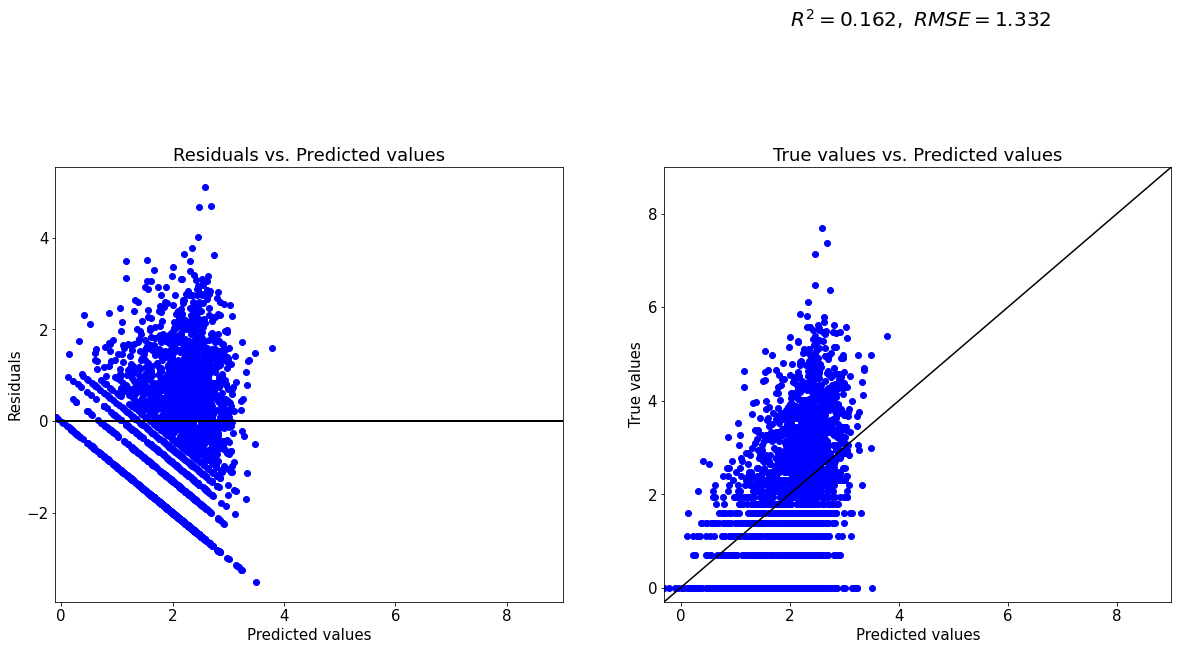

In [41]:
model.diagnostic_plot(lr.predict(X_test_scaled), y_test, ylim =None)

# B. Support Vector Regressor

In [42]:
model.eval_metric_test(svr.predict(X_test_scaled), y_test, model_nm = 'Support vector regressor')

Test prediction results for Support vector regressor
---------------------------------------------
{'RMSE = 1.33', 'R^2 = 0.165', 'MAE = 1.07'}
---------------------------------------------


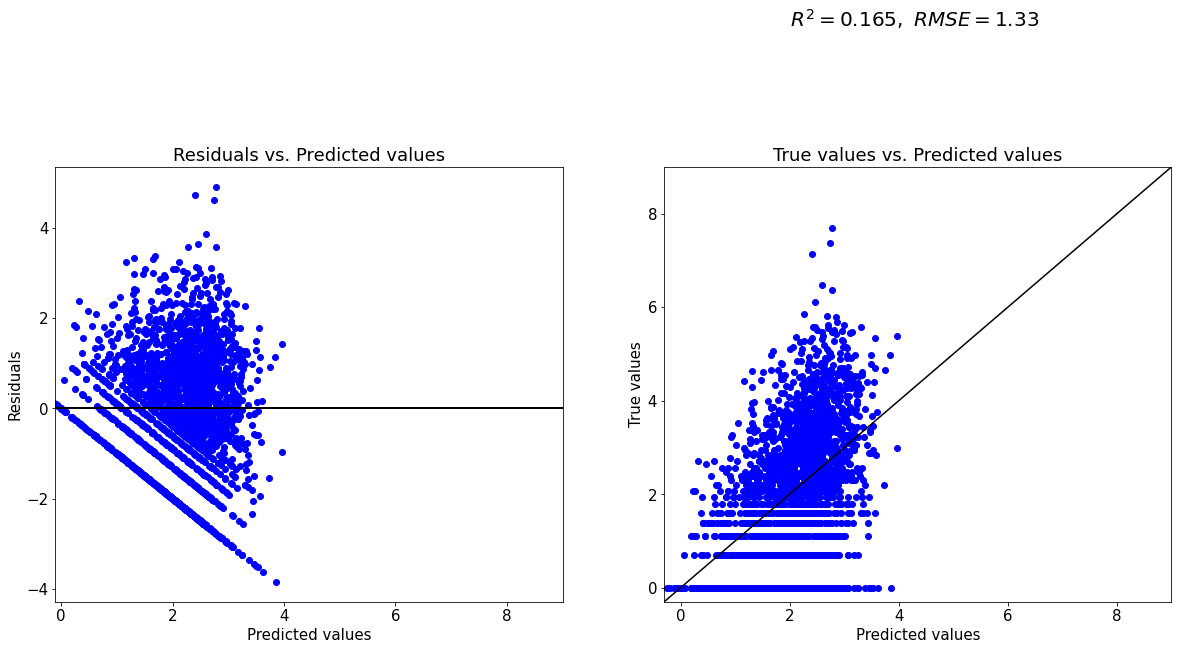

In [43]:
model.diagnostic_plot(svr.predict(X_test_scaled), y_test, ylim = None)

# C. Random Forest Regressor

In [44]:
model.eval_metric_test(rf.predict(X_test_scaled), y_test, model_nm = 'Random forest regressor')

Test prediction results for Random forest regressor
---------------------------------------------
{'RMSE = 1.323', 'MAE = 1.071', 'R^2 = 0.173'}
---------------------------------------------


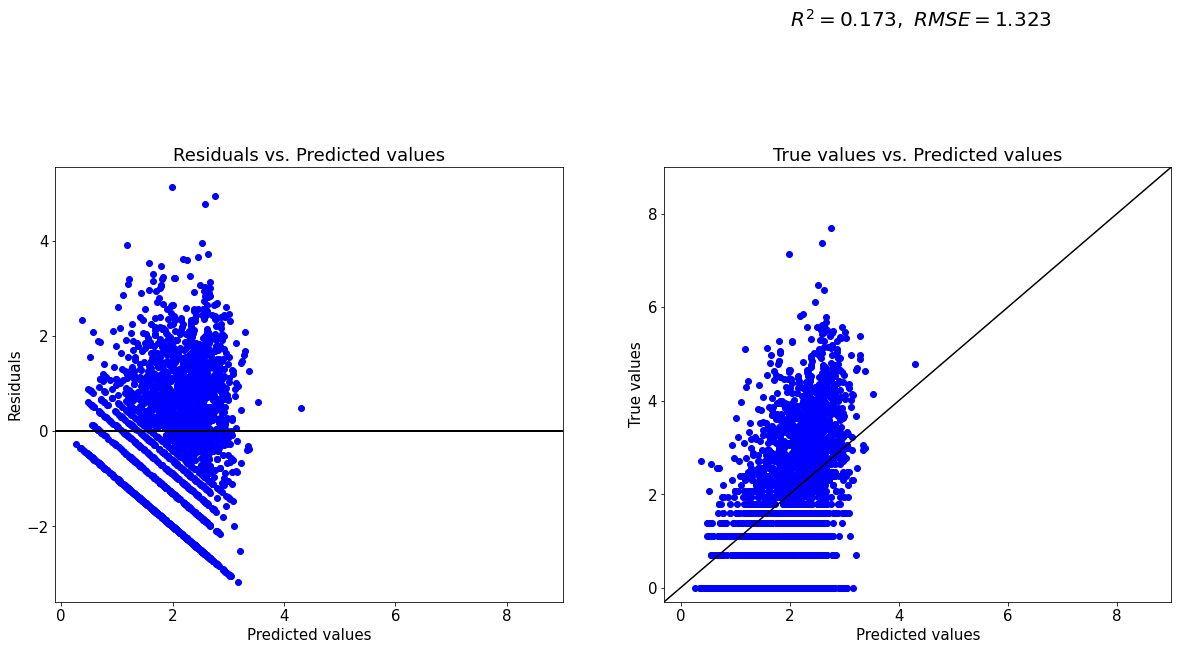

In [45]:
model.diagnostic_plot(rf.predict(X_test_scaled), y_test, ylim = None)

# D. LGBM Regressor

In [46]:
model.eval_metric_test(lgbm.predict(X_test_scaled), y_test, model_nm = 'LGBM regressor')

Test prediction results for LGBM regressor
---------------------------------------------
{'MAE = 1.134', 'RMSE = 1.411', 'R^2 = 0.059'}
---------------------------------------------


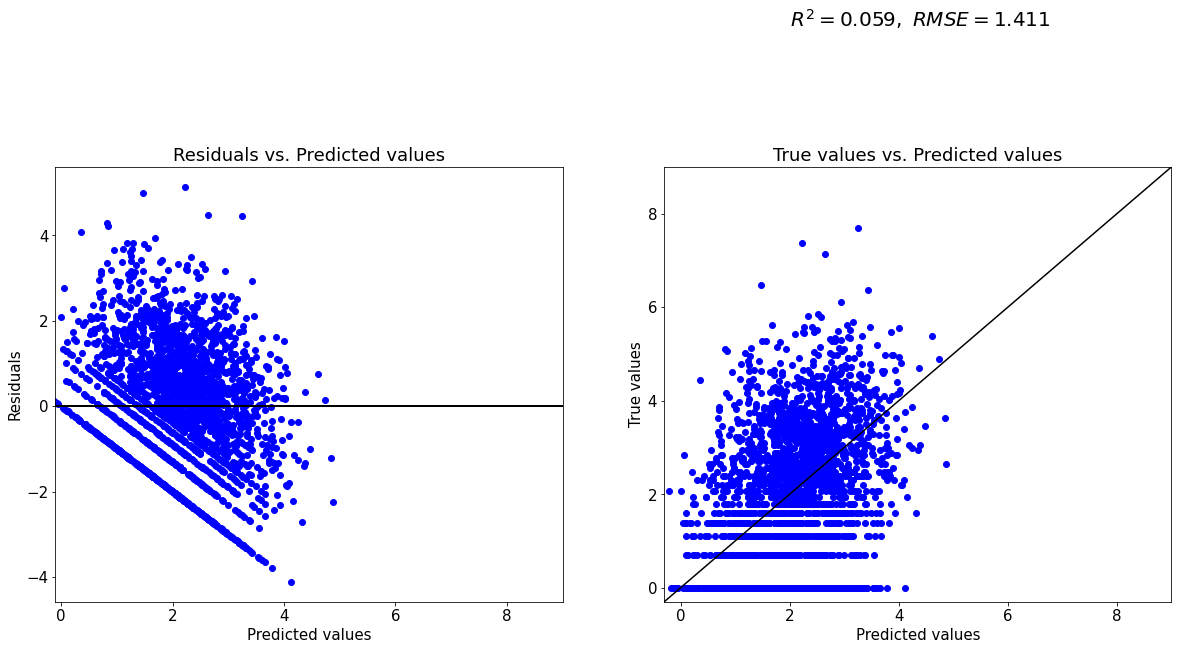

In [47]:
model.diagnostic_plot(lgbm.predict(X_test_scaled), y_test, ylim = None)